In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

item_cat = pd.read_csv("./item_categories.csv")
items = pd.read_csv("./items.csv")
sales_train_raw = pd.read_csv("./sales_train.csv")
shops = pd.read_csv("./shops.csv")
test_raw = pd.read_csv("./test.csv")

In [2]:
df = sales_train_raw.copy()

In [3]:
# 일별로 정리
df['date'] = pd.to_datetime(df['date'],format='%d.%m.%Y')

temp = df[['date','date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
cntday = temp.groupby(['date', 'date_block_num','shop_id', 'item_id']).sum()

temp = df[['date', 'date_block_num','shop_id', 'item_id', 'item_price']]
price = temp.groupby(['date','date_block_num', 'shop_id', 'item_id']).mean()

df = pd.merge(cntday,price,on=['date', 'date_block_num','shop_id', 'item_id'])

del cntday, price

df = df.reset_index()
df

,date,date_block_num,shop_id,item_id,item_cnt_day,item_price
0,2013-01-01,0,2,991,1.0,99.0
1,2013-01-01,0,2,1472,1.0,2599.0
2,2013-01-01,0,2,1905,1.0,249.0
3,2013-01-01,0,2,2920,2.0,599.0
4,2013-01-01,0,2,3320,1.0,1999.0
...,...,...,...,...,...,...
2935816,2015-10-31,33,59,20730,1.0,499.0
2935817,2015-10-31,33,59,20866,1.0,699.0
2935818,2015-10-31,33,59,20949,1.0,5.0
2935819,2015-10-31,33,59,21369,1.0,169.0


In [4]:
# item_cnt_day, item_price 가 1보다 작은 이상치 삭제
# item_price 연산 -> 아래 block(월별)으로 집계 시 다시 나눠주어 한달동안 팔린 평균값으로 대체될 예정
df.drop(df[df['item_cnt_day'] < 1].index, inplace=True)
df.drop(df[df['item_price'] < 1].index, inplace=True)
df['item_price'] = df['item_price'] * df['item_cnt_day']
df

,date,date_block_num,shop_id,item_id,item_cnt_day,item_price
0,2013-01-01,0,2,991,1.0,99.0
1,2013-01-01,0,2,1472,1.0,2599.0
2,2013-01-01,0,2,1905,1.0,249.0
3,2013-01-01,0,2,2920,2.0,1198.0
4,2013-01-01,0,2,3320,1.0,1999.0
...,...,...,...,...,...,...
2935816,2015-10-31,33,59,20730,1.0,499.0
2935817,2015-10-31,33,59,20866,1.0,699.0
2935818,2015-10-31,33,59,20949,1.0,5.0
2935819,2015-10-31,33,59,21369,1.0,169.0


In [5]:
# 상품 가격 outlier
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3-q1
    lower_bound = 0
    upper_bound = q3+(iqr * 3)
    return upper_bound, lower_bound

outliers_iqr(df['item_price'])

(3613.0, 0)

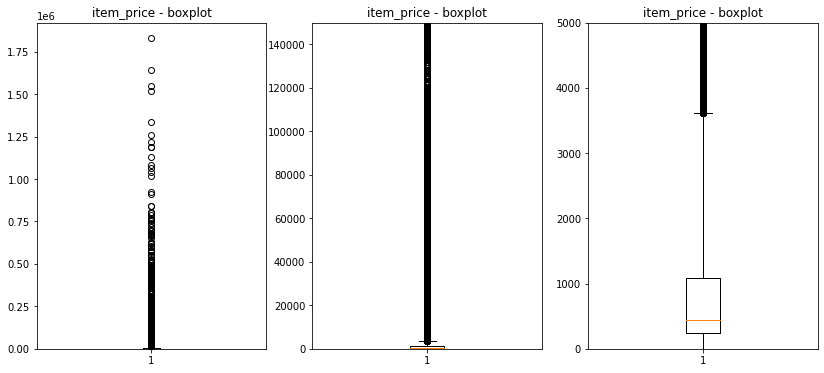

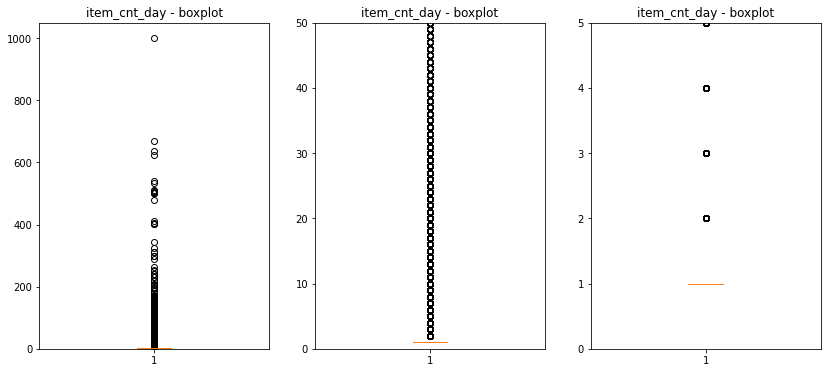

In [6]:
# item_price, cnt 모두 정상치 범위를 한참 벗어났다.
plt.rcParams["figure.figsize"] = (14,6)
plt.subplot(131)
plt.boxplot(df['item_price'],whis=3)
plt.title('item_price - boxplot')
plt.ylim(0.0, )

plt.subplot(132)
plt.boxplot(df['item_price'],whis=3)
plt.title('item_price - boxplot')
plt.ylim(0.0, 150000)


plt.subplot(133)
plt.boxplot(df['item_price'],whis=3)
plt.title('item_price - boxplot')
plt.ylim(0.0,5000)
plt.show()

plt.subplot(131)
plt.boxplot(df['item_cnt_day'],whis=3)
plt.title('item_cnt_day - boxplot')
plt.ylim(0,)

plt.subplot(132)
plt.boxplot(df['item_cnt_day'],whis=3)
plt.title('item_cnt_day - boxplot')
plt.ylim(0,50)


plt.subplot(133)
plt.boxplot(df['item_cnt_day'],whis=3)
plt.title('item_cnt_day - boxplot')
plt.ylim(0,5)
plt.show()


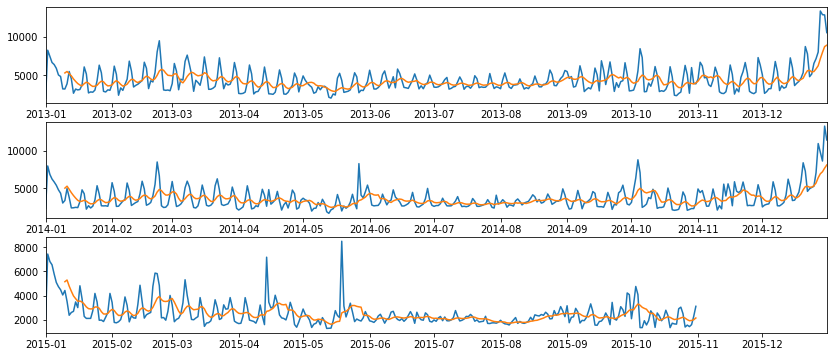

In [7]:
# 전체 일별 판매량
# 전체적으로 월별 비슷한 양상을 보인다.

rolling_window = 10 # 이동평균 15일

plt.subplot(3,1,1)
df_2013 = df[df.date <= datetime.datetime(2013, 12, 31,0,0,0)][['date', 'item_cnt_day']].groupby(['date']).sum()
plt.plot(df_2013)
plt.xlim(datetime.datetime(2013, 1, 1,0,0,0), datetime.datetime(2013, 12, 31,0,0,0))
plt.plot(df_2013.rolling(window=rolling_window).mean())

plt.subplot(3,1,2)
df_2014 = df[(datetime.datetime(2013, 12, 31,0,0,0) < df.date)&(df.date <=  datetime.datetime(2014, 12, 31,0,0,0))][['date', 'item_cnt_day']].groupby(['date']).sum()
plt.plot(df_2014)
plt.xlim(datetime.datetime(2014, 1, 1,0,0,0), datetime.datetime(2014, 12, 31,0,0,0))
plt.plot(df_2014.rolling(window=rolling_window).mean())

plt.subplot(3,1,3)
df_2015 = df[df.date > datetime.datetime(2014, 12, 31,0,0,0)][['date', 'item_cnt_day']].groupby(['date']).sum()
plt.plot(df_2015)
plt.xlim(datetime.datetime(2015, 1, 1,0,0,0), datetime.datetime(2015, 12, 31,0,0,0))
plt.plot(df_2015.rolling(window=rolling_window).mean())

In [8]:
from sklearn.metrics import mean_squared_error
rmse1 = mean_squared_error(df_2013.item_cnt_day, df_2014.item_cnt_day) ** 0.5
rmse2 = mean_squared_error(df_2013.iloc[:len(df_2015),:].item_cnt_day, df_2015.item_cnt_day) ** 0.5
rmse3 = mean_squared_error(df_2014.iloc[:len(df_2015),:].item_cnt_day, df_2015.item_cnt_day) ** 0.5
rmse1, rmse2, rmse3

(1494.5840443927616, 2192.199434778256, 1450.8840771278585)

In [9]:
train = sales_train_raw.copy()
train['date'] = pd.to_datetime(train['date']).dt.strftime('%Y-%m')

ndf = train.pivot_table(index = ['shop_id','item_id'], values = ['item_cnt_day'], columns = ['date_block_num'], fill_value = 0, aggfunc='sum')
ndf.reset_index(inplace=True)

In [10]:
ndf

shop_id item_id item_cnt_day                                    \
date_block_num                            0   1  2  3  4  5  6  7  8  9 10 11   
0                    0      30            0  31  0  0  0  0  0  0  0  0  0  0   
1                    0      31            0  11  0  0  0  0  0  0  0  0  0  0   
2                    0      32            6  10  0  0  0  0  0  0  0  0  0  0   
3                    0      33            3   3  0  0  0  0  0  0  0  0  0  0   
4                    0      35            1  14  0  0  0  0  0  0  0  0  0  0   
...                ...     ...          ...  .. .. .. .. .. .. .. .. .. .. ..   
424119              59   22154            1   0  0  0  0  0  0  0  0  0  0  0   
424120              59   22155            0   0  0  0  0  0  1  0  0  0  0  0   
424121              59   22162            0   0  0  0  0  0  0  0  0  0  0  0   
424122              59   22164            0   0  0  0  0  0  0  0  0  0  0  0   
424123              59   22167            0   0  0  0  0  0  0  0  0  1  0  2   

                                                                               \
date_block_num 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32   
0               0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   
1               0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   
2               0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   
3               0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   
4               0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   
...            .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. ..   
424119          0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   
424120          0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   
424121          0  0  0  0  0  0  0  0  0  0  0  0  0  9  4  1  1  0  0  1  0   
424122          0  0  0  0  0  0  0  0  0  0  0  0  0  2  1  2  0  0  1  0  0   
424123          0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0   

                   
date_block_num 33  
0               0  
1               0  
2               0  
3               0  
4               0  
...            ..  
424119          0  
424120          0  
424121          0  
424122          0  
424123          0  

[424124 rows x 36 columns]

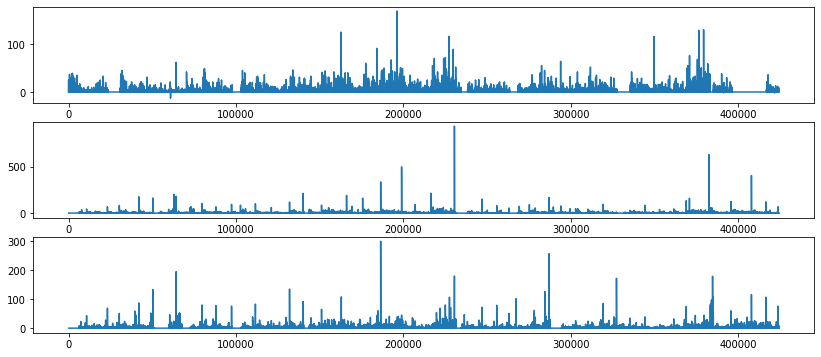

In [14]:
# x축은 각 인덱스의 shop_id/item_id 조합이고 y축은 판매량
# 0, 13, 25는 각각 13년 1월, 14년 1월, 15년 1월의 판매량
plt.subplot(3,1,1)
plt.plot(ndf['item_cnt_day'][0])
plt.subplot(3,1,2)
plt.plot(ndf['item_cnt_day'][13])
plt.subplot(3,1,3)
plt.plot(ndf['item_cnt_day'][25])